## End-of-month equity and bond market timing

The purpose of this notebook is to examine the out-of-sample performance of an investment strategy discussed in two papers, Etula et al (2019), and Hartley et al (2020), which focus on stocks and bonds respectively.  These two papers assert that reliable end-of-month are available because of the behavior of market participants, who demand liquidity prior to month-end to meet payment obligations.    

## Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from datetime import datetime
from scipy.interpolate import interp1d

# Used in analysis of both Hartley and Etula
short_rate_series_name = 'H15T3M'  # 3M series is available further back in time.

### Set to True to see some debugging logic (now unnecessary)

In [2]:
DEBUG_MODE = False;

In [3]:
def print_firstN_lastN(vec, N, prefix):
    """
    Print the first and last N elements of a vector for debugging.
    """
    if DEBUG_MODE:
        print(f"{prefix}: first {N} and last {N} elements:")
        for idx, val in enumerate(vec):
            if idx < N or idx >= len(vec) - N:
                print(f"{prefix}[{idx}] = {val:.4f}")

### Utility returning last business day, given year and month 

In [4]:
def lbusdate(year, month) -> datetime.date:
    """
    Return the last business day of the given month and year.
    """
    last_day_of_month = pd.Timestamp(year, month, 1) + pd.offsets.MonthEnd(0)
    return pd.date_range(end=last_day_of_month, periods=1, freq='B')[0].date()

### Utility to convert a sequence of 10y CMT yields to approximate bond prices

In [5]:
def H15CMT10Y_to_bond_prices(yields):
    """
    Convert a sequence of 10y CMT yields to approximate bond prices.
    
    Parameters:
        yields (array-like): Sequence of 10-year constant maturity yields.

    Returns:
        np.ndarray: Array of approximate bond prices.
    """
    freq = 2  # Semi-annual coupon payments
    face_value = 100
    maturity = 10  # Years
    periods = maturity * freq

    returns = np.zeros_like(yields)
    coupon_rates = yields[:-1] / freq  # Use yesterday's yield for coupon rate
    cash_flows = np.tile(coupon_rates[:, np.newaxis] * face_value, (1, periods))
    cash_flows[:, -1] += face_value  # Add face value to the last cash flow

    # Calculate discount factors for yesterday and today
    discount_exponents = np.arange(1, periods + 1)
    discount_factors_yesterday = (1 + yields[:-1][:, np.newaxis] / freq) ** -discount_exponents
    discount_factors_today = (1 + yields[1:][:, np.newaxis] / freq) ** -discount_exponents

    # Calculate bond prices
    yesterdays_prices = np.sum(cash_flows * discount_factors_yesterday, axis=1)
    todays_prices = yields[1:] / 252 + np.sum(cash_flows * discount_factors_today, axis=1)

    # Compute returns and bond prices
    returns[1:] = (todays_prices - yesterdays_prices) / yesterdays_prices
    bond_prices = face_value * np.cumprod(1 + returns)

    return bond_prices

### Utility to load time series data, skipping invalid (-999) values.

In [6]:
def load_series(file_name):
    """
    Load time series data, skipping invalid (-999) values.
    """
    data = pd.read_csv(f"{file_name}.csv", delimiter=',')
    return data[data.iloc[:, 1] != -999].values

### Utility to align a series with reference dates by finding the closest date.

In [7]:
def align_series(dates, ref_dates, ref_values):
    """
    Align a series with reference dates by finding the closest date.
    """
    aligned_values = [ref_values[np.argmin(np.abs(ref_dates - date))] for date in dates]
    return np.array(aligned_values)

### Utility to calculate cumulative product of returns.

In [8]:
def calculate_cumulative_returns(data):
    """
    Calculate cumulative product of returns.
    """
    return np.cumprod(1 + data[:, 1])

### testOneSeries(): Calculate end-of-month returns for two periods, in-sample and out-of-sample.  

In [9]:
def testOneSeries(trl_series_name, short_rate_series_name, full_window, focus_window, in_sample_period, out_of_sample_period, in_sample_msg, out_of_sample_msg):
    """
    Test and plot a time series against short rate data for multiple periods.
    """
    # Load and clean series
    sr_ts = load_series(short_rate_series_name)  # Short rate time series
    trl_ts = load_series(trl_series_name)  # Total return level time series

    # Compute total returns
    tr_ts = np.column_stack((trl_ts[1:, 0], (trl_ts[1:, 1] / trl_ts[:-1, 1] - 1)))
    trl_ts = trl_ts[1:, :]  # Align lengths

    # Compute excess returns
    xsr_series_name = f"{trl_series_name}-XS"
    sr_values = align_series(tr_ts[:, 0], sr_ts[:, 0], sr_ts[:, 1])
    xsr_values = tr_ts[:, 1] - (sr_values / (100 * 252))
    xsr_ts = np.column_stack((tr_ts[:, 0], xsr_values))

    # Convert dates
    trl_dates = pd.to_datetime(trl_ts[:, 0].astype(int).astype(str), format='%Y%m%d')
    xsr_dates = pd.to_datetime(xsr_ts[:, 0].astype(int).astype(str), format='%Y%m%d')

    # Calculate cumulative returns
    trl_values = np.cumprod(1 + tr_ts[:, 1])
    xsr_values = np.cumprod(1 + xsr_ts[:, 1])

    # Plot TRL vs XSL comparison
    plt.figure()
    plt.plot(trl_dates, np.log10(trl_values), label='TRL', linewidth=2.0, color='blue')
    plt.plot(xsr_dates, np.log10(xsr_values), label='XSL', linewidth=2.0, color='red')
    plt.title(f"{trl_series_name}: TRL vs XSL Full Sample NAV Growth Comparison (log10)")
    plt.legend()
    plt.show()

    # Test for in-sample and out-of-sample periods
    testOneSeriesForOnePeriod(xsr_ts, xsr_series_name, full_window, focus_window, in_sample_period, in_sample_msg)
    testOneSeriesForOnePeriod(xsr_ts, xsr_series_name, full_window, focus_window, out_of_sample_period, out_of_sample_msg)

### Generate and save plots (of SRs, mean and log cumulative returns) to a single PDF.

In [10]:
def save_plots_to_pdf(series_name, beg_YYYYMMDD, end_YYYYMMDD, extra_msg, 
                      all_windows, all_sr, grand_sr, all_cnt, 
                      SR_all_returns, SR_focus_returns_only, SR_non_focus_returns_only,
                      SE_SR_all_returns, SE_SR_focus_returns_only, SE_SR_non_focus_returns_only,
                      all_mu, grand_mu, all_se, log_cum_all_returns, 
                      log_cum_focus_returns, log_cum_non_focus_returns, this_return_ts):
    """
    Generate and save plots (Sharpe Ratios, Mean Returns, Log Cumulative Returns) to a single PDF.
    """
    figure_pdf_fn = f"{series_name}_{beg_YYYYMMDD}_{end_YYYYMMDD}.pdf"
    with PdfPages(figure_pdf_fn) as pdf:
        
        # Plot 1: Annualized SR by Day from EOM
        plt.figure()
        plt.bar(all_windows, all_sr)
        plt.axhline(grand_sr, color='red', linewidth=2.0)
        plt.axhline(y=0, color='k', linestyle='-')
        title = f"{series_name.replace('_', '-')}: Annualized SR by Day from EOM\n{extra_msg} ({beg_YYYYMMDD}-{end_YYYYMMDD})\nmean obs count = {np.mean(all_cnt):.1f}d"
        plt.title(title)
        plt.xticks(all_windows, [str(i) for i in all_windows])
        pdf.savefig()
        plt.show()
        plt.close()

        # Plot 2: Sharpe Ratios by Window Category
        plt.figure()
        categories = ['All Returns', 'Focus Returns Only', 'Non-Focus Returns Only']
        Sharpe_Ratios = [SR_all_returns, SR_focus_returns_only, SR_non_focus_returns_only]
        SE_Sharpe_Ratios = [SE_SR_all_returns, SE_SR_focus_returns_only, SE_SR_non_focus_returns_only]
        plt.bar(categories, Sharpe_Ratios)
        plt.errorbar(categories, Sharpe_Ratios, yerr=SE_Sharpe_Ratios, fmt='none', color='black')
        plt.axhline(y=0, color='k', linestyle='-')
        title = f"{series_name.replace('_', '-')}: Sharpe Ratios by Window Category\n{extra_msg} ({beg_YYYYMMDD}-{end_YYYYMMDD})"
        plt.title(title)
        pdf.savefig()
        plt.show()
        plt.close()

        # Plot 3: Mean Daily Return by Days from EOM
        plt.figure()
        plt.bar(all_windows, all_mu)
        plt.axhline(grand_mu, color='red', linewidth=2.0)
        plt.axhline(y=0, color='k', linestyle='-')
        plt.errorbar(all_windows, all_mu, yerr=all_se, fmt='none', color='black')
        title = f"{series_name.replace('_', '-')}: Mean Daily Return by Days from EOM\n{extra_msg} ({beg_YYYYMMDD}-{end_YYYYMMDD})\nmean obs count = {np.mean(all_cnt):.1f}d"
        plt.title(title)
        plt.xticks(all_windows, [str(i) for i in all_windows])
        pdf.savefig()
        plt.show()
        plt.close()

        # Plot 4: Log Cumulative Returns
        dts = pd.to_datetime(this_return_ts[:, 0].astype(int).astype(str), format='%Y%m%d')
        plt.figure()
        plt.plot(dts, log_cum_all_returns, 'r', linewidth=2.0, label='All Returns')
        plt.plot(dts, log_cum_focus_returns, 'b', linewidth=2.0, label='Focus Returns')
        plt.plot(dts, log_cum_non_focus_returns, 'k', linewidth=2.0, label='Non-Focus Returns')
        plt.axhline(y=0, color='k', linestyle='-')
        plt.legend()
        title = f"{series_name.replace('_', '-')}: Log Cumulative Returns\n{extra_msg} ({beg_YYYYMMDD}-{end_YYYYMMDD})"
        plt.title(title)
        pdf.savefig()
        plt.show()
        plt.close()

    print(f"Saved plots to {figure_pdf_fn}")

### testOneSeriesForOnePeriod() - summarize returns by end-of-month for a return series for one period

In [11]:
def testOneSeriesForOnePeriod(return_ts, series_name, all_windows, focus_window, analysis_period, extra_msg):
    """
    Analyze a series for a given period, extracting statistics and date components.
    """
    # Extract start and end dates for the analysis period
    beg_YYYYMMDD, end_YYYYMMDD = analysis_period

    # Filter the return_ts array based on the date range
    date_indexes_of_interest = np.where(
        (return_ts[:, 0] >= beg_YYYYMMDD) & (return_ts[:, 0] <= end_YYYYMMDD)
    )[0]
    this_return_ts = return_ts[date_indexes_of_interest, :]
    return_dates = this_return_ts[:, 0]
    return_values = this_return_ts[:, 1]

    # Convert return_dates to datetime and extract year, month, day components
    dts = pd.to_datetime(return_dates.astype(int).astype(str), format='%Y%m%d')
    YYYYs, MMs, DDs = dts.year, dts.month, dts.day

    if 0:
        # Print leading and trailing elements for debugging
        print_firstN_lastN(YYYYs, 3, 'YYYYs')
        print_firstN_lastN(MMs, 3, 'MMs')
        print_firstN_lastN(DDs, 3, 'DDs')

    # Extract dates
    dates = pd.to_datetime(this_return_ts[:, 0].astype(int).astype(str), format='%Y%m%d')

    # Calculate previous and current business month end dates
    prev_bus_month_end = [
        lbusdate(y - 1, 12) if m == 1 else lbusdate(y, m - 1) 
        for y, m in zip(dates.year, dates.month)
    ]
    curr_bus_month_end = [lbusdate(y, m) for y, m in zip(dates.year, dates.month)]

    # Calculate business day differences
    dx_to_prev = np.array([
        np.busday_count(str(date.date()), str(prev)) 
        for date, prev in zip(dates, prev_bus_month_end)
    ])

    dx_to_curr = np.array([
        np.busday_count(str(date.date()), str(curr)) 
        for date, curr in zip(dates, curr_bus_month_end)
    ])

    # Identify business month-ends
    bus_month_end = np.where(
        ((MMs[:-1] == 12) & (MMs[1:] == 1)) | (MMs[:-1] < MMs[1:]), 
        1, 
        0
    )
    bus_month_end = np.append(bus_month_end, 0)  # Align array length

    # Classify day differences based on conditions
    dx_class = np.where(
        (dx_to_curr == -999) & (dx_to_prev == -999), -999,  # Both invalid
        np.where(
            dx_to_curr == -999, dx_to_prev,              # Current invalid
            np.where(                                    # Compare absolute values
                dx_to_prev == -999, dx_to_curr, 
                np.where(abs(dx_to_prev) > abs(dx_to_curr), dx_to_curr, dx_to_prev)
            )
        )
    )

    # Copy of dx_class for transparency
    all_dx_class_pre = dx_class.copy()
    
    # Clip dx_class to ensure it stays within the bounds of all_windows
    dx_class = np.clip(dx_class, min(all_windows), max(all_windows))

    # Ccompute statistics 
    all_mu = [np.mean(this_return_ts[dx_class == wx, 1]) for wx in all_windows]
    all_sd = [np.std(this_return_ts[dx_class == wx, 1]) for wx in all_windows]
    all_cnt = [np.sum(dx_class == wx) for wx in all_windows]
    all_se = [sd / np.sqrt(cnt) if cnt > 0 else 0 for sd, cnt in zip(all_sd, all_cnt)]
    all_sr = [
        (mu / sd * np.sqrt(252)) if sd > 0 else 0
        for mu, sd in zip(all_mu, all_sd)
    ]
    all_se_sr = [
        (np.sqrt(1 + (sr ** 2 / 2)) / np.sqrt(cnt)) if cnt > 0 else 0
        for sr, cnt in zip(all_sr, all_cnt)
    ]
    
    # Compute grand statistics
    grand_mu = np.mean(this_return_ts[:, 1])
    grand_sd = np.std(this_return_ts[:, 1])
    grand_se = grand_sd / np.sqrt(len(this_return_ts[:, 1]))
    grand_sr = (grand_mu / grand_sd * np.sqrt(252)) if grand_sd > 0 else 0
    grand_se_sr = (np.sqrt(1 + (grand_sr ** 2 / 2)) / np.sqrt(len(this_return_ts[:, 1]))) if grand_sd > 0 else 0

    # Calculate cumulative returns for all, focus, and non-focus periods
    all_returns = this_return_ts[:, 1]
    log_cum_all_returns = np.log10(np.cumprod(1 + all_returns))

    focus_mask = np.isin(dx_class, focus_window)
    focus_returns = np.where(focus_mask, all_returns, 0)
    log_cum_focus_returns = np.log10(np.cumprod(1 + focus_returns))

    non_focus_returns = np.where(~focus_mask, all_returns, 0)
    log_cum_non_focus_returns = np.log10(np.cumprod(1 + non_focus_returns))

    # Extract focus and non-focus returns only
    focus_returns_only = this_return_ts[focus_mask, 1]
    non_focus_returns_only = this_return_ts[~focus_mask, 1]

    den = np.nanstd(all_returns) 
    SR_all_returns = np.mean(all_returns) / np.nanstd(all_returns) * np.sqrt(252)
    SR_focus_returns_only = np.mean(focus_returns_only) / np.nanstd(focus_returns_only) * np.sqrt(252)
    SR_non_focus_returns_only = np.mean(non_focus_returns_only) / np.nanstd(non_focus_returns_only) * np.sqrt(252)

    SE_SR_all_returns = np.sqrt(1 + (SR_all_returns ** 2 / 2)) / np.sqrt(len(all_returns))
    SE_SR_focus_returns_only = np.sqrt(1 + (SR_focus_returns_only ** 2 / 2)) / np.sqrt(len(focus_returns_only))
    SE_SR_non_focus_returns_only = np.sqrt(1 + (SR_non_focus_returns_only ** 2 / 2)) / np.sqrt(len(non_focus_returns_only))
    
    # Show Plots
    save_plots_to_pdf(
        series_name=series_name,
        beg_YYYYMMDD=beg_YYYYMMDD,
        end_YYYYMMDD=end_YYYYMMDD,
        extra_msg=extra_msg,
        all_windows=all_windows,
        all_sr=all_sr,
        grand_sr=grand_sr,
        all_cnt=all_cnt,
        SR_all_returns=SR_all_returns,
        SR_focus_returns_only=SR_focus_returns_only,
        SR_non_focus_returns_only=SR_non_focus_returns_only,
        SE_SR_all_returns=SE_SR_all_returns,
        SE_SR_focus_returns_only=SE_SR_focus_returns_only,
        SE_SR_non_focus_returns_only=SE_SR_non_focus_returns_only,
        all_mu=all_mu,
        grand_mu=grand_mu,
        all_se=all_se,
        log_cum_all_returns=log_cum_all_returns,
        log_cum_focus_returns=log_cum_focus_returns,
        log_cum_non_focus_returns=log_cum_non_focus_returns,
        this_return_ts=this_return_ts
    )

    # Assemble all intermediate results into a dictionary for DF
    results_dict = {
        "Date": this_return_ts[:, 0],
        "Return": this_return_ts[:, 1],
        "Year": YYYYs,
        "Month": MMs,
        "Day": DDs,
        "Business_Month_End": bus_month_end,
        "DX_to_Prev": dx_to_prev,
        "DX_to_Curr": dx_to_curr,
        "DX_Class": dx_class,
        "Non_Focus_Returns": non_focus_returns,
        "Focus_Returns": focus_returns,
        "Log_Cum_All_Returns": log_cum_all_returns,
        "Log_Cum_Focus_Returns": log_cum_focus_returns,
        "Log_Cum_Non_Focus_Returns": log_cum_non_focus_returns,
    }
    # Convert results dictionary to a DataFrame
    df = pd.DataFrame(results_dict)

    # Export the DataFrame to a CSV file
    intermediate_results_fn = f"{series_name}_{beg_YYYYMMDD}_{end_YYYYMMDD}.csv"
    df.to_csv(intermediate_results_fn, index=False)

    print(f"Intermediate results saved to {intermediate_results_fn}")

    return df

### Wrapper function to call testOneSeries for a given series.

In [12]:
def run_series_analysis(series_name, short_rate_series, full_window, focus_window, 
                        in_sample_period, out_of_sample_period, in_sample_msg, out_of_sample_msg):
    """
    Wrapper function to call testOneSeries for a given series.
    """
    testOneSeries(
        series_name, short_rate_series,
        full_window, focus_window,
        in_sample_period, out_of_sample_period,
        in_sample_msg, out_of_sample_msg
    )

### Convert 10Y CMT yields into bond total returns, save to CSV.

In [13]:
def convert_yield_to_bond_prices(input_file, output_file):
    """
    Converts yield series into bond total returns and saves to CSV.
    """
    # Load yield data and filter invalid rows
    yield_ts = pd.read_csv(input_file, delimiter=',').values
    yield_ts = yield_ts[yield_ts[:, 1] != -999]

    # Convert yields to bond prices
    bondtr_ts = yield_ts.copy()
    bondtr_ts[:, 1] = H15CMT10Y_to_bond_prices(0.01 * yield_ts[:, 1])

    # Save bond prices to CSV
    np.savetxt(output_file, bondtr_ts, delimiter=',', fmt='%.2f')
    print(f"Converted bond prices saved to {output_file}")

### ETULA Analysis

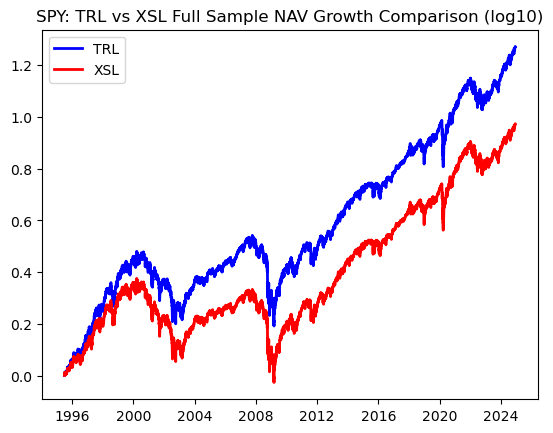

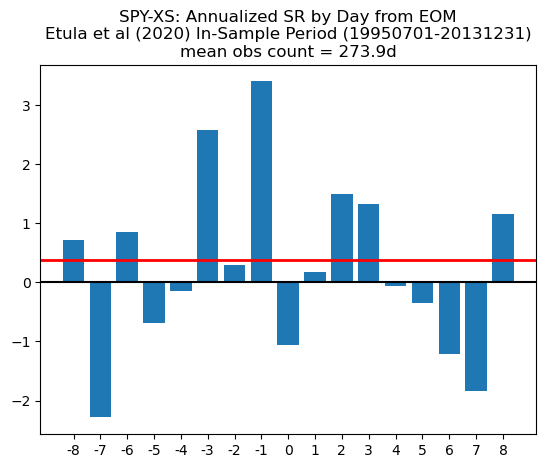

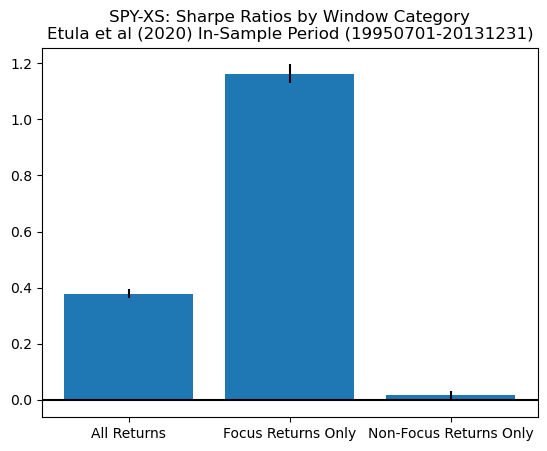

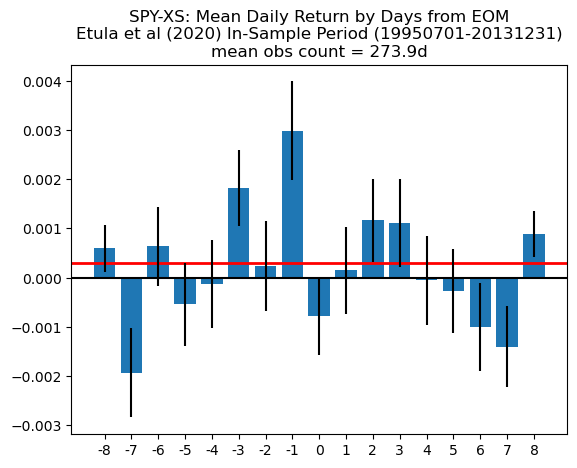

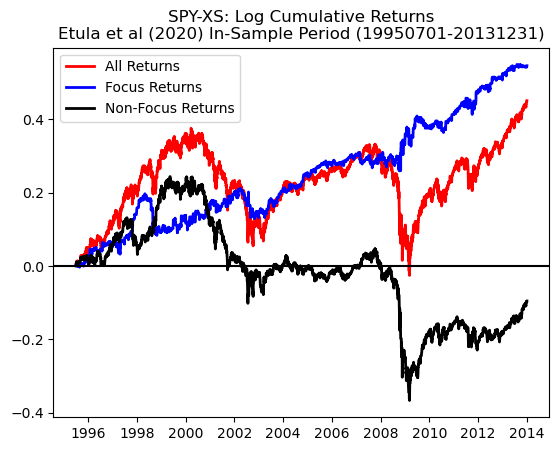

Saved plots to SPY-XS_19950701_20131231.pdf
Intermediate results saved to SPY-XS_19950701_20131231.csv


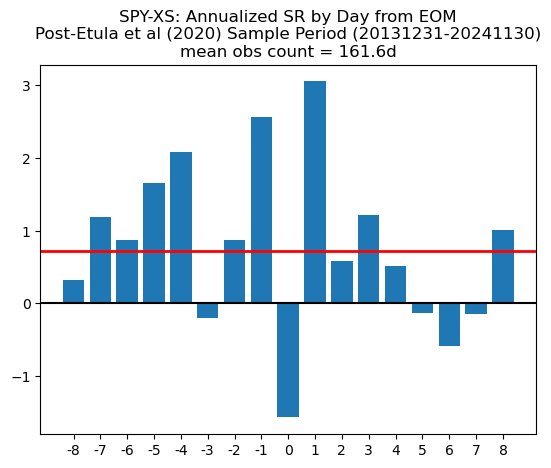

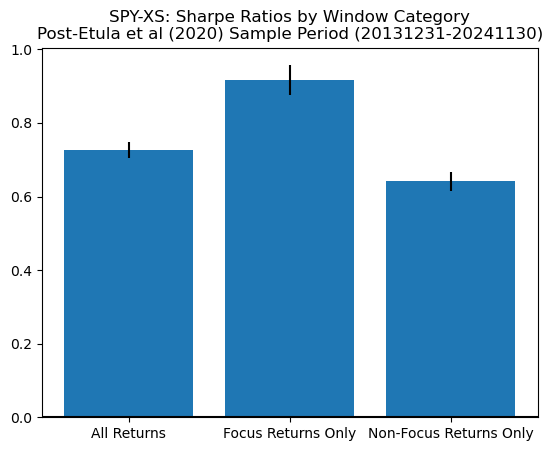

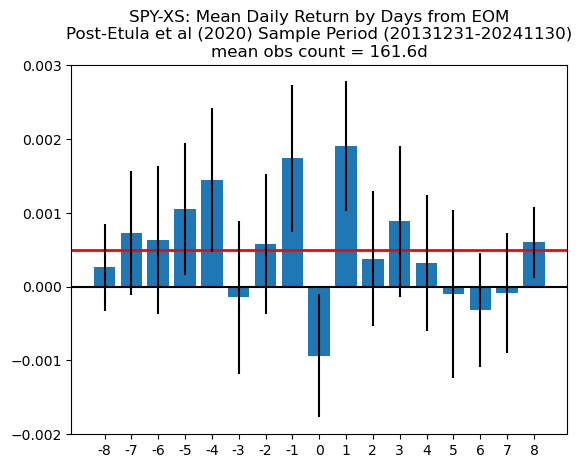

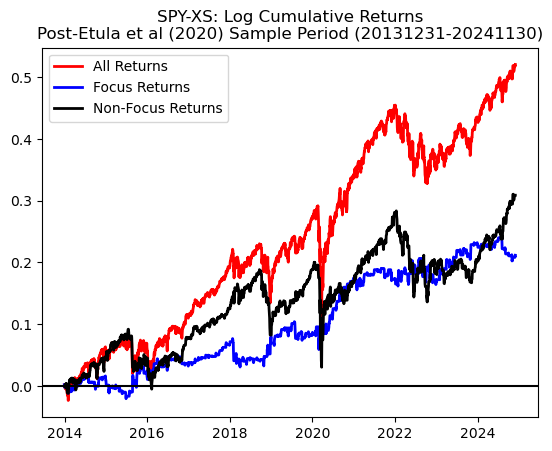

Saved plots to SPY-XS_20131231_20241130.pdf
Intermediate results saved to SPY-XS_20131231_20241130.csv


In [14]:
# ETULA Analysis
etula_config = {
    "trl_series_name": 'SPY',
    "full_window": np.arange(-8, 9),
    "focus_window": np.arange(-3, 4),
    "in_sample_period": [19950701, 20131231],
    "out_of_sample_period": [20131231, 20241130],
    "in_sample_msg": 'Etula et al (2020) In-Sample Period',
    "out_of_sample_msg": 'Post-Etula et al (2020) Sample Period'
}

run_series_analysis(
    etula_config["trl_series_name"], short_rate_series_name,
    etula_config["full_window"], etula_config["focus_window"],
    etula_config["in_sample_period"], etula_config["out_of_sample_period"],
    etula_config["in_sample_msg"], etula_config["out_of_sample_msg"]
)

### HARTLEY Analysis

Converted bond prices saved to H15T10Y-BONDTR.csv


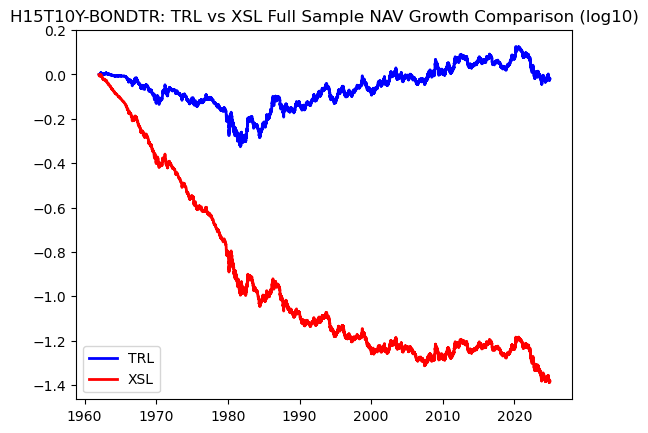

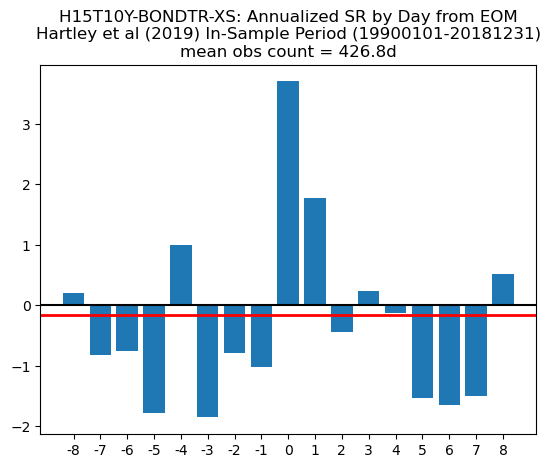

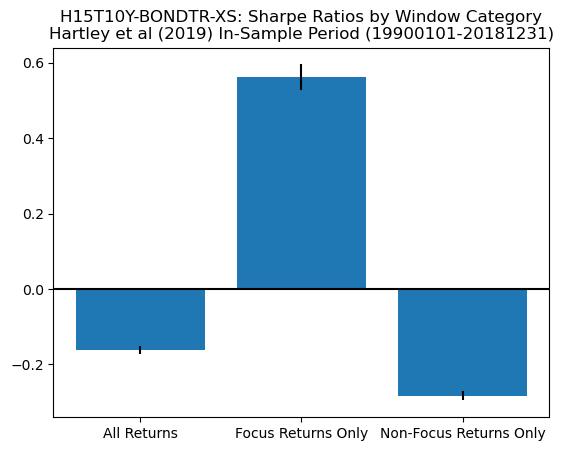

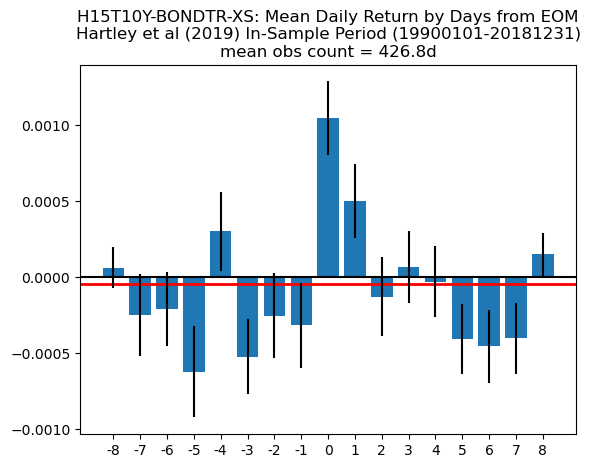

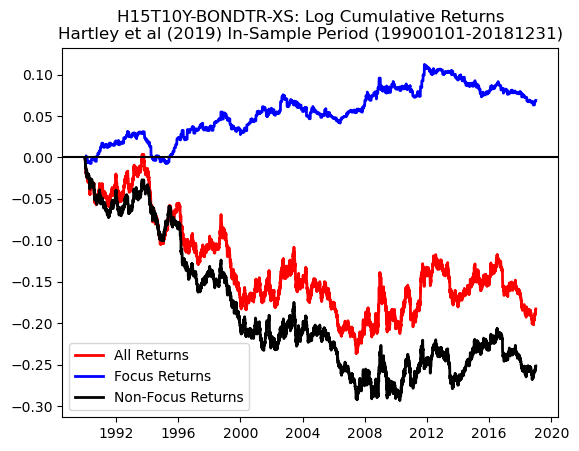

Saved plots to H15T10Y-BONDTR-XS_19900101_20181231.pdf
Intermediate results saved to H15T10Y-BONDTR-XS_19900101_20181231.csv


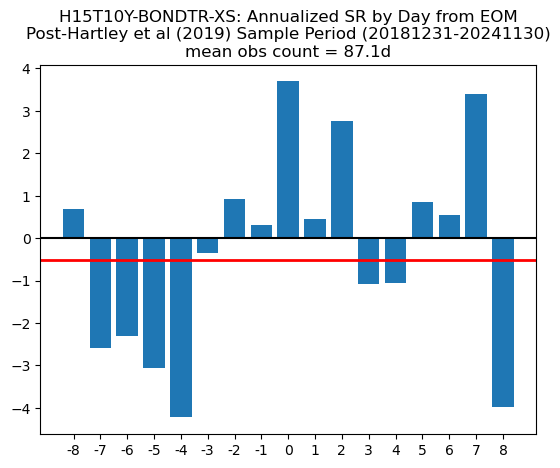

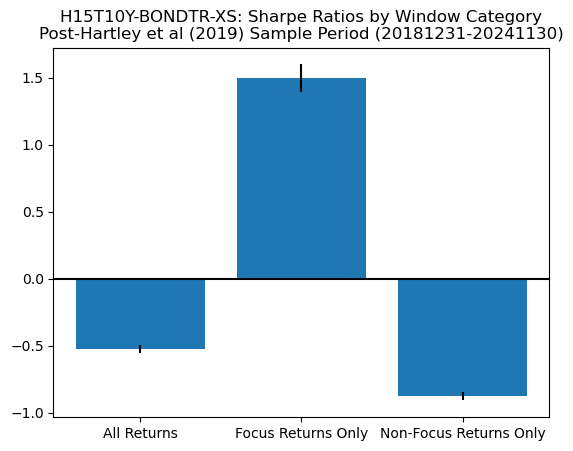

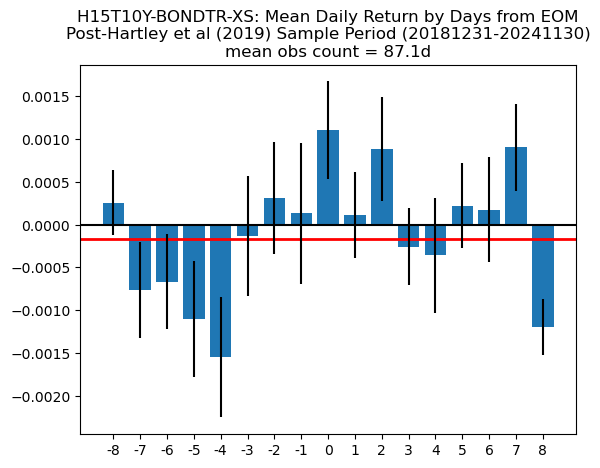

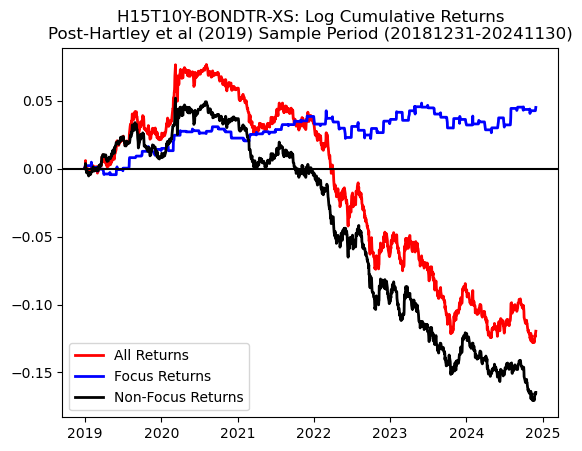

Saved plots to H15T10Y-BONDTR-XS_20181231_20241130.pdf
Intermediate results saved to H15T10Y-BONDTR-XS_20181231_20241130.csv


In [15]:
# HARTLEY Analysis
hartley_input_file = 'FRB_H15T10Y.csv'
hartley_output_file = 'H15T10Y-BONDTR.csv'

convert_yield_to_bond_prices(hartley_input_file, hartley_output_file)

hartley_config = {
    "trl_series_name": 'H15T10Y-BONDTR',
    "full_window": np.arange(-8, 9),
    "focus_window": np.arange(-2, 1),
    "in_sample_period": [19900101, 20181231],
    "out_of_sample_period": [20181231, 20241130],
    "in_sample_msg": 'Hartley et al (2019) In-Sample Period',
    "out_of_sample_msg": 'Post-Hartley et al (2019) Sample Period'
}

run_series_analysis(
    hartley_config["trl_series_name"], short_rate_series_name,
    hartley_config["full_window"], hartley_config["focus_window"],
    hartley_config["in_sample_period"], hartley_config["out_of_sample_period"],
    hartley_config["in_sample_msg"], hartley_config["out_of_sample_msg"]
)